## 7.1 深度卷积神经网络（AlexNet）

### 7.1.2 AlexNet

In [4]:
import torch
from torch import nn
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [ ]:

net=nn.Sequential(
    nn.Conv2d(1,96,kernel_size=11,stride=4,padding=1),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2),
    nn.Conv2d(96,256,kernel_size=5,padding=2),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2),
    nn.Conv2d(256,384,kernel_size=3,padding=1),nn.ReLU(),
    nn.Conv2d(384,384,kernel_size=3,padding=1),nn.ReLU(),
    nn.Conv2d(384,256,kernel_size=3,padding=1),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2),
    nn.Flatten(),
    nn.Linear(6400,4096),nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096,4096),nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096,10))

In [10]:
X=torch.randn(1,1,224,224)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

In [3]:
X=torch.ones(1,1,4,4)
# print(X)
net=nn.Sequential(nn.Conv2d(1,2,kernel_size=2))
# print(net(X))
weights=nn.Conv2d(1,2,kernel_size=2).weight.data.numpy
print(weights)

<built-in method numpy of Tensor object at 0x000002B6445F1400>


### 7.1.3 读取数据集

In [18]:
from torchvision import transforms
from torch.utils import data
import torchvision
from IPython import display


def get_dataloader_workers():
    '''使用四个进程来读取'''
    return 4

def load_data_fashion_mnist(batch_size, resize=None): 
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    # transforms.ToTensor(): 将 PIL 图像或 numpy 数组转换为 PyTorch 张量，并自动归一化到 [0,1]
    # transforms.Resize(resize): 如果指定了 resize 参数，调整图像大小
    # transforms.Compose(trans): 组织多个变换操作成一个流水线，便于复用相同的预处理流程
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))


batch_size=128
train_iter,test_iter=load_data_fashion_mnist(batch_size,resize=224)

### 7.1.4 训练AlexNet

In [19]:
class Accumulator: 
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]


def accuracy(y_hat, y): 
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
        # print(y_hat)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())



def evaluate_accuracy_gpu(net,data_iter,device=None):

    
    if isinstance(net,nn.Module):  #isinstance(对象, 类名):如果对象是指定类或其子类的实例，返回 True,否则返回 False
        net.eval()    #设置为评估模式,关闭 dropout 和 batch normalization 的随机性
        
        # 检查 device 参数是否为空（None、False、0、空字符串等）
        # 如果用户没有指定设备，就执行下面的自动检测逻辑
        # net.parameters()
        # 返回模型所有参数的迭代器
        # 这些参数是 nn.Parameter 对象，包含权重和偏置
        # iter(net.parameters())
        # 将参数迭代器转换为可迭代对象
        # next(iter(net.parameters()))
        # 获取第一个参数（任意一个参数都可以）
        # 因为所有参数都在同一个设备上
        # .device
        # 获取该参数所在的设备（CPU 或 GPU）
        if  not device:
            device = next(iter(net.parameters())).device
    #正确预测的数量，总预测的数量
    metric=Accumulator(2)
    with torch.no_grad():

        #  解释：将数据移动到指定设备：
        # 如果 X 是列表（如BERT的多输入），分别移动每个元素
        # 否则直接移动整个张量
        # 移动 y 到设备
        for X,y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
        return metric[0] / metric[1]

import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
def use_svg_display():
    # 设置Matplotlib使用SVG格式显示
    backend_inline.set_matplotlib_formats('svg')

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Animator: 
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                ylim=None, xscale='linear', yscale='linear',
                fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):   
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

import time
class Timer: 
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()
    def start(self):
        """启动计时器"""
        self.tik = time.time()  
    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()
    
def try_gpu(i=0): 
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)。"""
    
    #     Xavier 均匀初始化公式
    # 从均匀分布 U[-a, a] 中采样，其中：
    # a = gain × √(6 / (fan_in + fan_out))
    # 公式解释
    # U[-a, a]：在 -a 到 a 之间的均匀分布
    # gain：缩放因子，取决于激活函数
    # fan_in：层的输入单元数
    # fan_out：层的输出单元数
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)  #将初始化函数应用到网络的所有模块
    print('training on', device)
    net.to(device)   #转移到GPU上  
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = Accumulator(3)   
        net.train()  #将模型设置为训练模式（启用dropout、batch norm等）
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()  #优化器步进：更新模型参数
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])  #累计损失（乘以批次大小得到总损失），累计正确预测数，累计样本数
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.330, train acc 0.880, test acc 0.878
1315.7 examples/sec on cuda:0


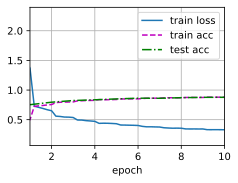

In [12]:
lr,num_epochs=0.01,10
train_ch6(net,train_iter,test_iter,num_epochs,lr,try_gpu())

## 7.2 使用块的网络

### 7.2.1 VCC块


In [26]:
import torch
from torch import nn

def vgg_block(num_convs,in_channels,out_channels):
    """该函数有三个参数，分别对应于卷积层的数量num_convs、输入通道的数量in_channels 和输出通道的数
    量out_channels."""
    layers=[]
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1))
        layers.append(nn.ReLU())
        in_channels=out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

### 7.2.2 VGG网络

In [28]:
conv_arch=((1,64),(1,128),(2,256),(2,512),(2,512))

In [30]:
def vgg(conv_arch):
    conv_blks=[]
    in_channels=1
    #卷积层部分
    for (num_convs,out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs,in_channels,out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks,nn.Flatten(),
        #全连接层部分
        nn.Linear(out_channels*7*7,4096),nn.ReLU(),nn.Dropout(0.5),
        nn.Linear(4096,4096),nn.ReLU(),nn.Dropout(0.5),
        nn.Linear(4096,10)
    )

net=vgg(conv_arch)

In [31]:
X=torch.randn(size=(1,1,224,224))
for blk in net:
    X=blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


### 7.2.3 训练模型

In [32]:
#由于VGG‐11比AlexNet计算量更大，因此我们构建了一个通道数较少的网络，足够用于训练Fashion‐MNIST数据集。
ratio=4
small_conv_arch=[(pair[0],pair[1]//ratio) for pair in conv_arch]
net=vgg(small_conv_arch)

loss 0.173, train acc 0.936, test acc 0.922
996.6 examples/sec on cuda:0


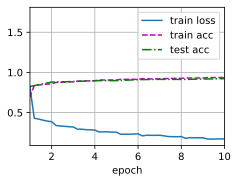

In [34]:
lr,num_epochs,batch_size=0.05,10,128
train_iter,test_iter=load_data_fashion_mnist(batch_size,resize=224)
train_ch6(net,train_iter,test_iter,num_epochs,lr,try_gpu())

## 7.3 NiN块

### 7.3.1 NiN块

In [18]:
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
    nn.ReLU(),
    nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
    nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

### 7.3.2 NiN模型


In [19]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    # 将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten())

In [20]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


loss 0.336, train acc 0.876, test acc 0.865
1192.5 examples/sec on cuda:0


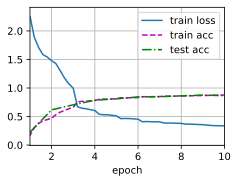

In [21]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter =load_data_fashion_mnist(batch_size, resize=224)
train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())

## 7.4 含并行连结的网络（GoogLeNet）

### 7.4.1 Inception块

In [2]:
import torch
from torch import nn
from torch.nn import functional as F


In [3]:
class Inception(nn.Module):
    #c1-c4是每条路径的输出通道数
    def __init__(self,in_channels,c1,c2,c3,c4,**kwargs):
        super(Inception,self).__init__(**kwargs)
        #线路1，单1x1卷积层
        self.p1_1=nn.Conv2d(in_channels,c1,kernel_size=1)
        #线路2，1x1卷积层接3x3卷积层
        self.p2_1=nn.Conv2d(in_channels,c2[0],kernel_size=1)
        self.p2_2=nn.Conv2d(c2[0],c2[1],kernel_size=3,padding=1)
        #线路三，1x1接5x5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3x3最大汇聚层后接1x1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self,x):
        # F.relu() 是纯函数，没有内部状态
        # nn.ReLU() 是一个类实例，需要维护状态
        # 在这个 Inception 实现中，使用 F.relu() 主要是为了代码简洁性和编写便利性
        p1=F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)


### 7.4.2 Goole模型

In [4]:



b1=nn.Sequential(nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
                 nn.ReLU(),
                 nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

In [5]:
b2=nn.Sequential(nn.Conv2d(64,64,kernel_size=7,stride=2,padding=3),
                 nn.ReLU(),
                 nn.Conv2d(64,192,kernel_size=3,padding=1),
                 nn.ReLU(),
                 nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

In [6]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [7]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [15]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [16]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 6, 6])
Sequential output shape:	 torch.Size([1, 480, 3, 3])
Sequential output shape:	 torch.Size([1, 832, 2, 2])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


### 7.4.3 模型训练

loss 0.255, train acc 0.904, test acc 0.882
2858.0 examples/sec on cuda:0


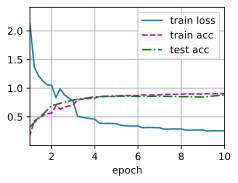

In [17]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=96)
train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())

## 7.5 批量规范化

### 7.5.3 从零实现

In [13]:
def batch_norm(X,gamma,beta,moving_mean,moving_var,eps,momentum):
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat=(X-moving_mean)/torch.sqrt(moving_var+eps)
    else:
        assert len(X.shape) in (2, 4) #这个函数只能对全连接层和卷积层起作用
        if len(X.shape) == 2:
            mean = X.mean(dim=0)  #对每一列求平均
            var = ((X - mean)**2).mean(dim=0)  #求方差
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean=X.mean(dim=(0,2,3),keepdim=True)   #对每一个输出通道中的所有值求平均方差
            var=((X-mean)**2).mean(dim=(0,2,3),keepdim=True)
         # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X- mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0- momentum) * mean
        moving_var = momentum * moving_var + (1.0- momentum) * var
    Y = gamma * X_hat + beta # 缩放和移位
    return Y, moving_mean.data, moving_var.data

moving_mean: 移动平均均值（用于推理模式）
训练过程中积累的全局均值估计

moving_var: 移动平均方差（用于推理模式）
训练过程中积累的全局方差估计

eps: 极小常数
防止分母为0，增加数值稳定性
通常设为 1e-5

momentum: 动量参数
控制移动平均的更新速度
范围 [0, 1]，常用值 0.9 或 0.99

In [16]:
class BatchNorm(nn.Module):
    #num_features:完全连接层的输出数量或卷积层的输出通道数
    #num_dims:2表示完全连接层，4表示卷积层
    def __init__(self,num_features,num_dims):
        super().__init__()
        if num_dims==2:
            shape=(1,num_features)
        else:
            shape=(1,num_features,1,1)
        #参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma=nn.Parameter(torch.ones(shape))
        self.beta=nn.Parameter(torch.zeros(shape))
        #非模型参数的变化初始量为0和1
        self.moving_mean=torch.zeros(shape)
        self.moving_var=torch.ones(shape)

    def forward(self, X):
        #如果X不在内存上，将moving_mean和moving_var复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        #保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var,
            eps=1e-5, momentum=0.9)
        return Y

### 7.5.4 使用批量规范化层的LeNet

In [17]:
#批量规范化是在卷积层或全连接层之后、相应的激活函数之前应用的

net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4),
                    nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16,kernel_size=5), BatchNorm(16, num_dims=4),
                    nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(16 * 4 * 4, 120),
                    BatchNorm(120, num_dims=2), nn.Sigmoid(),
                    nn.Linear(120, 84), BatchNorm(84, num_dims=2),nn.Sigmoid(), 
                    nn.Linear(84, 10))

loss 0.270, train acc 0.900, test acc 0.827
55906.8 examples/sec on cuda:0


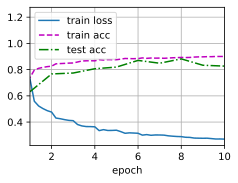

In [ ]:
lr, num_epochs, batch_size = 1.0, 10, 256  #可以用更大的学习率
train_iter, test_iter = load_data_fashion_mnist(batch_size)
train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())

In [21]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([3.6952, 2.6285, 0.4243, 2.5104, 1.9403, 4.5308], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([-3.8567,  1.1410, -0.2671, -0.6206, -2.4598, -2.3076], device='cuda:0',
        grad_fn=<ViewBackward0>))

### 7.5.5 简明实现

In [22]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(256, 120), nn.BatchNorm1d(120),
                    nn.Sigmoid(), nn.Linear(120, 84), nn.BatchNorm1d(84),
                    nn.Sigmoid(), nn.Linear(84, 10))

loss 0.254, train acc 0.907, test acc 0.868
81823.0 examples/sec on cuda:0


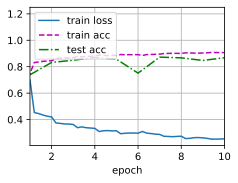

In [23]:
train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())

## 7.6 残差网络

### 7.6 2 残差块

In [24]:
import torch
from torch import nn
from torch.nn import functional as F


class Residual(nn.Module):  
    def __init__(self, input_channels, num_channels, use_1x1conv=False,
                 strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3,
                               padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3,
                               padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [25]:
#此代码生成两种类型的网络：一种是当use_1x1conv=False时，应用ReLU非线性函数之前，将输入添加到输出。
# 另一种是当use_1x1conv=True时，添加通过1×1卷积调整通道和分辨率。

#不改变步长的情况下，输入与输出一致
blk = Residual(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [26]:
#我们也可以在增加输出通道数的同时，减半输出的高和宽
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

### 7.6.3 ResNet模型

In [ ]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(
                Residual(input_channels, num_channels, use_1x1conv=True,
                         strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))  #*是将list展开
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

net = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [29]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


### 7.6.4 模型训练

loss 0.016, train acc 0.995, test acc 0.827
2779.9 examples/sec on cuda:0


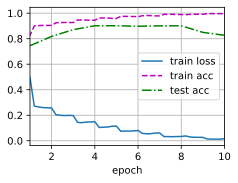

In [30]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=96)
train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())